In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('..')

import pickle
import re
from pathlib import Path

import torch
import datasets
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [3]:
pd.set_option('display.max_rows', 200)

In [4]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
texts_df = pd.read_csv('./notebooks/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [5]:
model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 1024
N_mem_tokens = 1

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [6]:
from pathlib import Path
from nltk import sent_tokenize
load_path = Path(f'./runs/{model_name}/')
data = []
for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
    if file_path.is_file():
        # Extract max_length from the file name using regex
        match = re.search(f'mem_{N_mem_tokens}_len_(\d+)\.pkl', file_path.name)
        if match:
            max_length = int(match.group(1))
        else:
            continue
        
        try:
            with open(file_path, 'rb') as f:
                d = pickle.load(f)
        except Exception as e:
            continue

    try:
        d = pickle.load(open(file_path, 'rb'))
    except:
        continue
    for el in d:
        data += [{
            'model_name': model_name,
            'max_length': el['max_length'],
            'n_mem_tokens': el['n_mem_tokens'],
            'original_loss': el['original_loss'],
            'best_loss': el['best_loss'],
            'best_accuracy': el['best_accuracy'],
            'shuffled': el['args'].get('shuffled', False),
            'sample_idx': el['args']['sample_idx'],
        }]
model_df = pd.DataFrame(data)
model_df = model_df[model_df['shuffled'] == False]
model_df.head()

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,sample_idx
0,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.642733,0.203631,1.0,False,0
1,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.730931,0.071622,1.0,False,1
2,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.926659,0.060715,1.0,False,2
3,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.557189,0.088668,1.0,False,3
4,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.959368,0.108064,1.0,False,4


In [7]:
device = 'cuda'
dtype = torch.bfloat16
use_flash_attention_2 = True

model = AutoModelForCausalLM.from_pretrained(model_name, use_flash_attention_2=use_flash_attention_2)
model = model.to(device)

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in LlamaForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtype

In [8]:
# sentences = sent_tokenize(text_sample)
# prefix_text = ' '.join(sentences[:len(sentences)//2])
# suffix_text = ' '.join(sentences[len(sentences)//2:])

# device = 'cuda'
# dtype = torch.bfloat16
# use_flash_attention_2 = True

# suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)

In [9]:
def adj_distr(p, i):
    p_i = p.gather(-1, i)
    device = p.device

    p_sorted, p_sorted_idx = p.sort(descending=True)
    # (p_i + p_sorted_0) / 2, (p_i + p_sorted_0 + p_sorted_1) / 3, ...
    p_cumsum = torch.concat([torch.zeros(1, p.shape[1], 1, device=device), p_sorted.cumsum(dim=-1)], dim=-1)
    p_thr = (p_cumsum + p_i) / (torch.arange(1, p.shape[-1]+2, device=device))
    # find min i such that p_thr_i >= p_sorted_{i}
    p_thr = p_thr[:,:,:-1]
    p_sorted = p_sorted

    new_p_i = torch.unsqueeze(((p_thr >= p_sorted) * p_thr).max(-1).values, dim=-1)
    moved = new_p_i - p_i
    return new_p_i, moved


p = torch.tensor([[[0.05, 0.4, 0.35, 0.2], [0.00, 0.00, 0.00, 1.0], [0.05, 0.35, 0.35, 0.25]]])
i = torch.tensor([[[3],[3],[3]]])
adj_distr(p, i)

(tensor([[[0.3167],
          [1.0000],
          [0.3167]]]),
 tensor([[[0.1167],
          [0.0000],
          [0.0667]]]))

In [10]:
h = []
max_h = []
eq_h = []
opt_h = []

for i in tqdm(range(len(model_df))):
    max_length = model_df['max_length'][i]
    sample_idx = model_df['sample_idx'][i]
    #print(max_length, sample_idx)
    sentences = sent_tokenize(texts_df['text'][sample_idx])
    prefix_text = ' '.join(sentences[:len(sentences)//2])
    suffix_text = ' '.join(sentences[len(sentences)//2:])

    suffix_inp = tokenizer(suffix_text, max_length=max_length, truncation=True, return_tensors='pt').to(device)
    with torch.cuda.amp.autocast(dtype=dtype):
        with torch.no_grad():
            out = model(**suffix_inp, labels=suffix_inp['input_ids'])
            logits = out['logits'][:,:-1,:]#.cpu()
            labels = suffix_inp['input_ids'][:,1:]#.cpu()
            labels_ohe = torch.nn.functional.one_hot(labels, num_classes=model.config.vocab_size)
            # take target token prob as max token prob (swap two probs)
            text_h = -(torch.nn.functional.log_softmax(logits, dim=-1) * labels_ohe).sum().item()
            text_max_h = -torch.nn.functional.log_softmax(logits, dim=-1).max(-1)[0].sum().item()

            probs = torch.nn.functional.softmax(logits, dim=-1)
            target_probs = torch.masked_select(probs.view(-1), labels_ohe.view(-1).type(torch.bool))
            max_token_probs = probs.max(-1)[0].view(-1)
            # make prob of max token and target token equal
            text_eq_h = -torch.log((max_token_probs - target_probs) / 2 + target_probs).sum().item()

            new_p_i, moved_p = adj_distr(probs, labels.unsqueeze(dim=-1))
            text_opt_h = -torch.log(new_p_i).sum().item()

            h += [text_h]
            max_h += [text_max_h]
            eq_h += [text_eq_h]
            opt_h += [text_opt_h]

model_df['text_h'] = h
model_df ['text_max_h'] = max_h
model_df ['text_eq_h'] = eq_h
model_df ['text_opt_h'] = opt_h

  0%|          | 0/450 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
100%|██████████| 450/450 [00:32<00:00, 13.89it/s]


In [11]:
logits.shape, labels.shape, labels_ohe.shape

(torch.Size([1, 1279, 32000]),
 torch.Size([1, 1279]),
 torch.Size([1, 1279, 32000]))

In [12]:
probs = torch.nn.functional.softmax(logits, dim=-1)
target_probs = torch.masked_select(probs.view(-1), labels_ohe.view(-1).type(torch.bool))
# max_token_probs = probs.max(-1)[0].view(-1)

In [57]:
p = probs[0,11,:]
t = target_probs[11]
p, t

(tensor([5.7911e-10, 9.8510e-10, 3.8150e-06,  ..., 3.0343e-09, 2.4141e-10,
         2.3631e-09], device='cuda:0'),
 tensor(0.0459, device='cuda:0'))

In [62]:
p = probs[0,121,:].clone()
t = target_probs[121].clone()

sort_ind = p.argsort(descending=True)

# take first two max, and make first max eq to second one
moved = 0.0

two_max_diff = (p[sort_ind[0]] - p[sort_ind[1]]) / 2
target_max_diff = (p[sort_ind[0]] - t) / 2

if t + target_max_diff > p[sort_ind[1]]:
    t1 = t + target_max_diff
    p[sort_ind[0]] -= target_max_diff
    moved += target_max_diff
else:
    t1 = t + two_max_diff
    p[sort_ind[0]] -= two_max_diff
    moved += two_max_diff

t, t1, moved, p[sort_ind[0]], p[sort_ind[1]], two_max_diff

(tensor(0.0206, device='cuda:0'),
 tensor(0.1142, device='cuda:0'),
 tensor(0.0937, device='cuda:0'),
 tensor(0.1142, device='cuda:0'),
 tensor(0.1045, device='cuda:0'),
 tensor(0.0517, device='cuda:0'))

In [ ]:
# #1
[0.05, 0.4, 0.35, 0.2]
cost: +0.05
[0.05, 0.35, 0.35, 0.25]
cost: +0.05
[0.05, 0.3, 0.35, 0.3]
cost + 0.025
[0.05, 0.3, 0.325, 0.325]
sum: 0.125

# #2
[0.05, 0.4, 0.35, 0.2]
cost: +0.05
[0.05, 0.35, 0.35, 0.25]
cost: +0.06
[0.05, 0.32, 0.32, 0.31]
cost: +0.0066
[0.05, 0.3166, 0.3166, 0.3166]
sum: 0.1166

In [76]:
def adjust_distribution(p, i):
    """
    Adjusts the probability distribution 'p' so that p[i] becomes the maximum probability
    with minimal total change.

    Parameters:
    - p: List of probabilities (should sum to 1).
    - i: Index of the target class (0-based indexing).

    Returns:
    - q: Adjusted list of probabilities.
    """
    import numpy as np

    n = len(p)
    p_i = p[i]
    # Exclude p_i and get the other probabilities with their indices
    other_probs = [(idx, prob) for idx, prob in enumerate(p)]# if idx != i]
    # Sort the other probabilities in decreasing order
    other_probs.sort(key=lambda x: x[1], reverse=True)

    # Extract sorted probabilities and their indices
    sorted_indices = [idx for idx, prob in other_probs]
    sorted_probs = [prob for idx, prob in other_probs]

    # Initialize variables
    cumulative_sum = p_i
    k = 0
    found = False

    # Iterate over k to find the minimal θ
    for k in range(1, n):
        # Sum of the largest k probabilities
        cumulative_sum += sorted_probs[k-1]
        theta = cumulative_sum / (k + 1)
        
        # Check constraints
        if k == n - 1 or theta >= sorted_probs[k]:
            found = True
            break

    if not found:
        # If θ wasn't found in the loop, set θ to p_i
        theta = p_i

    # Compute adjustments
    delta = theta - p_i  # Total probability to redistribute
    q = p.copy()         # Initialize adjusted probabilities
    q[i] = theta         # Increase p_i to θ

    # Adjust the selected probabilities
    for j in range(k):
        idx = sorted_indices[j]
        s_j = sorted_probs[j] - theta
        q[idx] = theta    # Decrease p_j to θ

    # Ensure the distribution sums to 1 (optional, to correct numerical errors)
    total_prob = sum(q)
    q = [prob / total_prob for prob in q]

    return q

# Example usage
p = [0.05, 0.4, 0.35, 0.2, 0]
i = 4  # Target index (0-based indexing)
adjusted_p = adjust_distribution(p, i)
print("Original distribution:", p)
print("Adjusted distribution:", adjusted_p)
print("cost:", adjusted_p[i] - p[i])

Original distribution: [0.05, 0.4, 0.35, 0.2, 0]
Adjusted distribution: [0.05, 0.25, 0.25, 0.2, 0.25]
cost: 0.25


In [239]:
new_p_i, moved = adj_distr(probs, labels.unsqueeze(dim=-1))
# print(moved.sum())
print(-torch.log(new_p_i).sum())

tensor(1747.9528, device='cuda:0')


In [265]:
torch.log((max_token_probs - target_probs) / 2 + target_probs).sum().item()

-1782.0506591796875

In [240]:
(torch.nn.functional.log_softmax(logits, dim=-1) * labels_ohe).sum()

tensor(-3498.4438, device='cuda:0')

In [242]:
torch.nn.functional.log_softmax(logits, dim=-1).max(-1)[0].sum().item()

-1408.0950927734375

In [153]:
torch.nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))

tensor(2.7353)

In [13]:
model_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,sample_idx,text_h,text_max_h,text_eq_h,text_opt_h
0,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.642733,0.203631,1.000000,False,0,166.492188,73.228523,92.698868,90.501999
1,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.730931,0.071622,1.000000,False,1,235.048676,87.481277,113.041595,110.054871
2,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.926659,0.060715,1.000000,False,2,184.379517,75.115845,94.120117,92.071472
3,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.557189,0.088668,1.000000,False,3,224.102951,83.483810,106.925186,104.596054
4,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.959368,0.108064,1.000000,False,4,186.440216,75.721710,92.833817,90.873459
...,...,...,...,...,...,...,...,...,...,...,...,...
445,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.984036,1.435763,0.716966,False,45,3816.582275,1473.422363,1869.715088,1830.738159
446,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.891081,1.675327,0.647381,False,46,3697.692871,1463.660767,1864.154053,1827.514404
447,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.709260,1.142075,0.773260,False,47,3465.144043,1374.855225,1744.357178,1709.892700
448,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.267641,0.803070,0.832682,False,48,2900.313232,1260.765503,1579.341309,1550.266479


In [14]:
model_df['diff_max_token_h'] = model_df['text_h'] - model_df['text_max_h']
model_df['diff_eq_h'] = model_df['text_h'] - model_df['text_eq_h']
model_df['diff_opt_h'] = model_df['text_h'] - model_df['text_opt_h']
model_df['diff_h'] = (model_df['original_loss'] - model_df['best_loss']) * model_df['max_length']
model_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,sample_idx,text_h,text_max_h,text_eq_h,text_opt_h,diff_max_token_h,diff_eq_h,diff_opt_h,diff_h
0,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.642733,0.203631,1.000000,False,0,166.492188,73.228523,92.698868,90.501999,93.263664,73.793320,75.990189,156.102567
1,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.730931,0.071622,1.000000,False,1,235.048676,87.481277,113.041595,110.054871,147.567398,122.007080,124.993805,234.195818
2,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.926659,0.060715,1.000000,False,2,184.379517,75.115845,94.120117,92.071472,109.263672,90.259399,92.308044,183.420402
3,princeton-nlp/Sheared-LLaMA-1.3B,64,1,3.557189,0.088668,1.000000,False,3,224.102951,83.483810,106.925186,104.596054,140.619141,117.177765,119.506897,221.985375
4,princeton-nlp/Sheared-LLaMA-1.3B,64,1,2.959368,0.108064,1.000000,False,4,186.440216,75.721710,92.833817,90.873459,110.718506,93.606400,95.566757,182.483477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.984036,1.435763,0.716966,False,45,3816.582275,1473.422363,1869.715088,1830.738159,2343.159912,1946.867188,1985.844116,1981.789398
446,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.891081,1.675327,0.647381,False,46,3697.692871,1463.660767,1864.154053,1827.514404,2234.032104,1833.538818,1870.178467,1556.165314
447,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.709260,1.142075,0.773260,False,47,3465.144043,1374.855225,1744.357178,1709.892700,2090.288818,1720.786865,1755.251343,2005.997467
448,princeton-nlp/Sheared-LLaMA-1.3B,1280,1,2.267641,0.803070,0.832682,False,48,2900.313232,1260.765503,1579.341309,1550.266479,1639.547729,1320.971924,1350.046753,1874.651794


/tmp/ipykernel_2515190/182803926.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


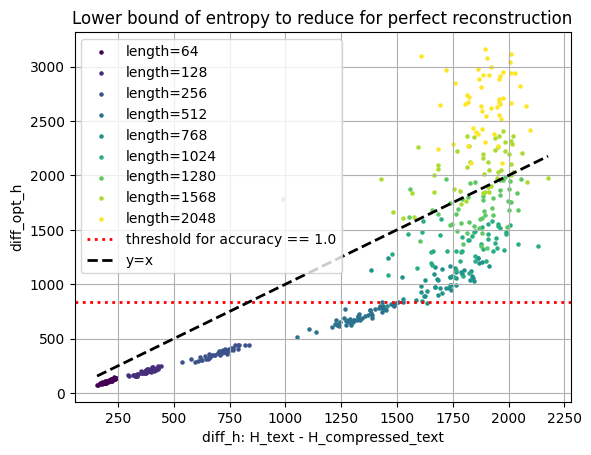

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_opt_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Generate values for the fitted curve
x_fit = np.linspace(min(model_df['diff_h']), max(model_df['diff_h']), 500)
y_fit = x_fit

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['diff_h'], 
        df['diff_opt_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )
plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label='y=x')

plt.xlabel('diff_h: H_text - H_compressed_text')
plt.ylabel('diff_opt_h')
plt.title('Lower bound of entropy to reduce for perfect reconstruction')

plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_2515190/3700765033.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


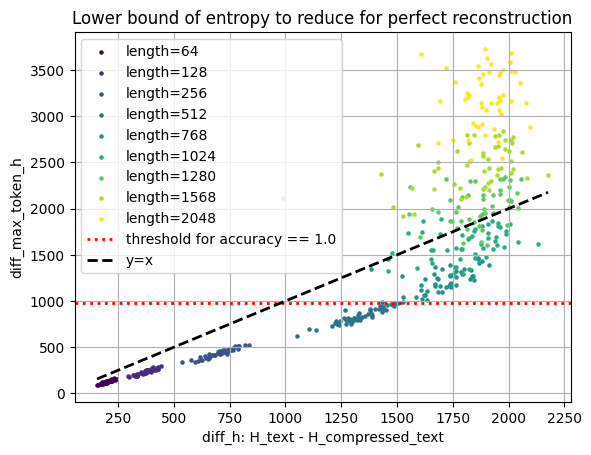

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_max_token_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Generate values for the fitted curve
x_fit = np.linspace(min(model_df['diff_h']), max(model_df['diff_h']), 500)
y_fit = x_fit

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['diff_h'], 
        df['diff_max_token_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )
plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label='y=x')

plt.xlabel('diff_h: H_text - H_compressed_text')
plt.ylabel('diff_max_token_h')
plt.title('Lower bound of entropy to reduce for perfect reconstruction')

plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_2515190/2673682159.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


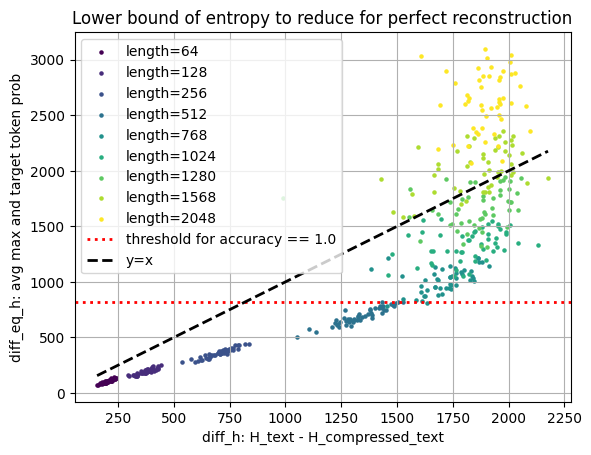

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_eq_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Generate values for the fitted curve
x_fit = np.linspace(min(model_df['diff_h']), max(model_df['diff_h']), 500)
y_fit = x_fit

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['diff_h'], 
        df['diff_eq_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )
plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label='y=x')

plt.xlabel('diff_h: H_text - H_compressed_text')
plt.ylabel('diff_eq_h: avg max and target token prob')
plt.title('Lower bound of entropy to reduce for perfect reconstruction')

plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_2515190/3835789667.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


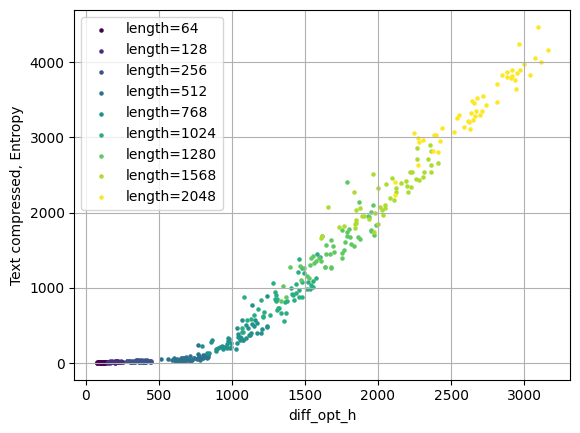

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_opt_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['diff_opt_h'],
        df['best_loss'] * df['max_length'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )
# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}'

plt.xlabel('diff_opt_h')
plt.ylabel('Text compressed, Entropy')

plt.grid()
plt.legend()
# sns.pairplot(model_df[model_df['best_accuracy'] <= 0.95], vars=['diff_h', 'diff_upper_h'], hue='best_accuracy')


/tmp/ipykernel_2515190/1942124798.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


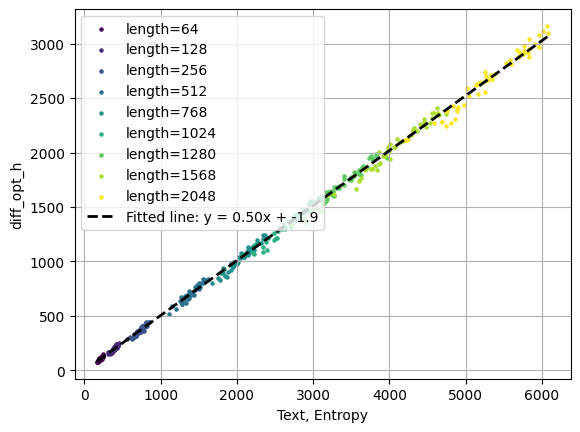

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * x + b

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_opt_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

x_data = model_df['original_loss'] * model_df['max_length']
y_data = model_df['diff_opt_h']

params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['original_loss'] * df['max_length'],
        df['diff_opt_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )

formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)
# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')

plt.ylabel('diff_opt_h')
plt.xlabel('Text, Entropy')

plt.grid()
plt.legend()
# sns.pairplot(model_df[model_df['best_accuracy'] <= 0.95], vars=['diff_h', 'diff_upper_h'], hue='best_accuracy')


/tmp/ipykernel_2515190/1435779616.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


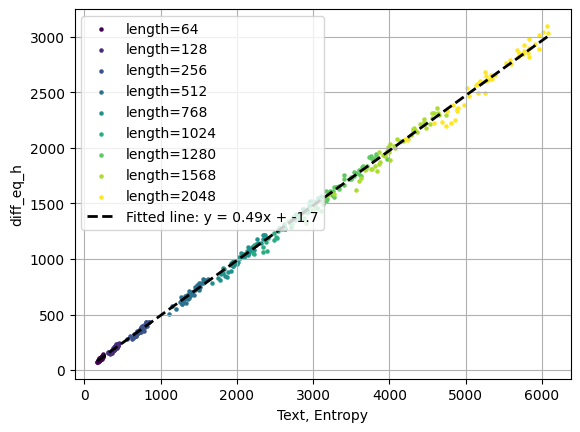

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * x + b

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_eq_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

x_data = model_df['original_loss'] * model_df['max_length']
y_data = model_df['diff_eq_h']

params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['original_loss'] * df['max_length'],
        df['diff_eq_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )

formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)
# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')

plt.ylabel('diff_eq_h')
plt.xlabel('Text, Entropy')

plt.grid()
plt.legend()
# sns.pairplot(model_df[model_df['best_accuracy'] <= 0.95], vars=['diff_h', 'diff_upper_h'], hue='best_accuracy')


/tmp/ipykernel_2515190/3842257531.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


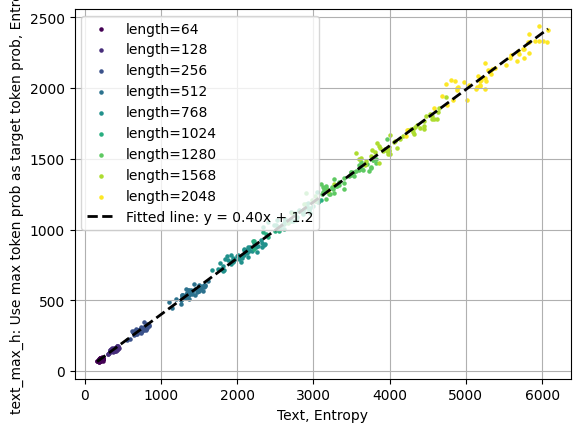

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * x + b

acc_thr = 1.0

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['text_max_h']).max()

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

x_data = model_df['text_h']
y_data = model_df['text_max_h']

params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        #df['original_loss'] * df['max_length'],
        df['text_h'],
        df['text_max_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )

formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)
# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')

plt.ylabel('text_max_h: Use max token prob as target token prob, Entropy')
plt.xlabel('Text, Entropy')

plt.grid()
plt.legend()

/tmp/ipykernel_2515190/1181783441.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


Text(0.5, 1.0, 'Perfect reconstuction with ideal compressor (.) vs compressor (x)')

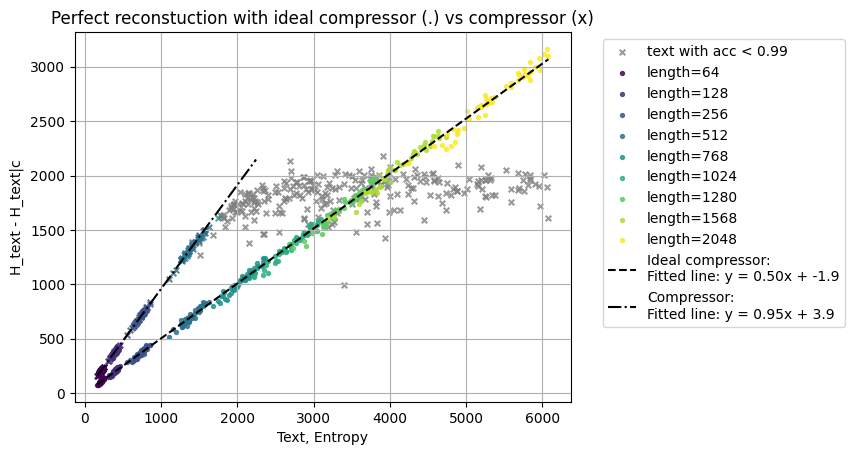

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * x + b

acc_thr = 0.99

alpha = 0.8
s = 8

best_loss_thr = (model_df[model_df['best_accuracy'] >= acc_thr]['diff_opt_h']).max()

model_thr_df = model_df[model_df['best_accuracy'] >= acc_thr]
model_below_thr_df = model_df[model_df['best_accuracy'] < acc_thr]

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

x_data = model_df['original_loss'] * model_df['max_length']
y_data = model_df['diff_opt_h']

params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

#-----
x_data = model_thr_df['original_loss'] * model_thr_df['max_length']
y_data = model_thr_df['diff_h']

params_diff_h, _ = curve_fit(polynomial, x_data, y_data)
a_diff_h, b_diff_h = params_diff_h
x_fit_diff_h = np.linspace(min(x_data), max(x_data) + 500, 500)
y_fit_diff_h = polynomial(x_fit_diff_h, *params_diff_h)

df = model_below_thr_df
plt.scatter(
    df['original_loss'] * df['max_length'],
    df['diff_h'],
    label=f'text with acc < {acc_thr}',
    color='grey',
    s=s*2, alpha=alpha,
    marker='x',
)

for max_length in sorted(model_df['max_length'].unique()):    
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter(
        df['original_loss'] * df['max_length'],
        df['diff_opt_h'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=s, alpha=alpha,
    )

    df = model_thr_df[model_thr_df['max_length'] == max_length]
    plt.scatter(
        df['original_loss'] * df['max_length'],
        df['diff_h'],
        #label=f'length={max_length}, real',
        color=global_color_map[max_length],
        s=s*2, alpha=alpha,
        marker='x',
    )

formula_label = f'Ideal compressor:\nFitted line: y = {a:.2f}x + {b:.1f}'
plt.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=1.5, label=formula_label)

formula_label = f'Compressor:\nFitted line: y = {a_diff_h:.2f}x + {b_diff_h:.1f}'
plt.plot(x_fit_diff_h, y_fit_diff_h, color='black', linestyle='-.', linewidth=1.5, label=formula_label)

# plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'threshold for accuracy == {acc_thr}')

plt.ylabel('H_text - H_text|c')
plt.xlabel('Text, Entropy')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Perfect reconstuction with optimal compressor (.) vs compressor (x)')

# sns.pairplot(model_df[model_df['best_accuracy'] <= 0.95], vars=['diff_h', 'diff_upper_h'], hue='best_accuracy')

/tmp/ipykernel_2515190/2583945243.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


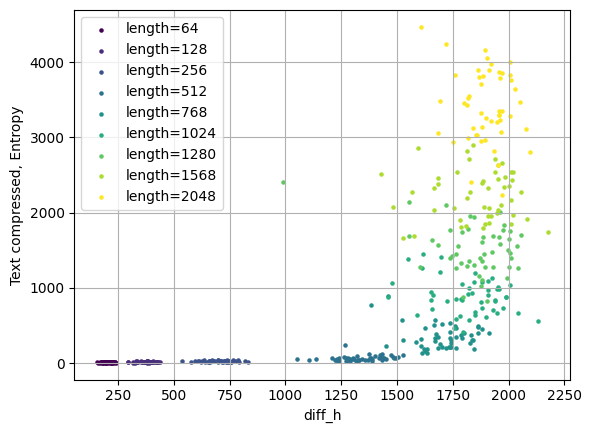

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_thr = 1.0

max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

for max_length in sorted(model_df['max_length'].unique()):
    df = model_df[model_df['max_length'] == max_length]
    plt.scatter( 
        df['diff_h'],
        df['best_loss'] * df['max_length'],
        label=f'length={max_length}',
        color=global_color_map[max_length],
        s=5,
    )

plt.xlabel('diff_h')
plt.ylabel('Text compressed, Entropy')

plt.grid()
plt.legend()
# sns.pairplot(model_df[model_df['best_accuracy'] <= 0.95], vars=['diff_h', 'diff_upper_h'], hue='best_accuracy')